<a href="https://colab.research.google.com/github/musman2012/ml-data_science/blob/master/SOH_Prediction/Phase_II_ML.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## Phase-II
This phase would have the following keys steps to perform:
* Apply labelling/binning on the data (yet to decided the technique)
* Make three clusters/subsets of the data on the basis of cycle variable
* Apply Association Rule Mining on the subsets
* Apply prediction technique to classify the target variable soh
* Evaluate Models Results

More explanation for the process and what I want to acheive 

In [2]:
from google.colab import drive
import os
drive.mount('/content/drive')
os.chdir("/content/drive/My Drive/Colab Notebooks")


Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&response_type=code&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly

Enter your authorization code:
··········
Mounted at /content/drive


In [3]:
import platform
import dill
dill.load_session('phase-II-ml.db')

FileNotFoundError: ignored

In [3]:
'''
authored by Muhammad Usman (musman14@student.bradford.ac.uk)

!pip install pandas
!pip install numpy
!pip install matplotlib
!pip install seaborn
'''
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns

FILE_PATH = "batteries_processed.csv"
bat_data = pd.read_csv(FILE_PATH, error_bad_lines = False)    # reading the data from csv file

/usr/local/lib/python3.6/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


### Removing the same features which were removed in Phase-I as well

In [4]:
filtered_data = bat_data.copy()
columns_to_drop = ['id', 'vin', 'vin_prefix', 'record_id','recorded_time', 'actual_time', 'arrival_time', 'powermode', 'mheader_vin', 'mheader_time', 'mheader_type', 'message','cat4', 'cat6', 'cat7', 'inlet_coolant_temp','cooling_energy_used', 'max_soh_cell', 'power_soh', 'min_soh', 'max_soh', 'min_soh_cell_id','imbalance_percent', 'parkingdata_hvbattavgsocoatevent', 'parkingdata_hvbattavtempatevent']
filtered_data = filtered_data.drop(columns=columns_to_drop)
filtered_data.head()

,odometer,ambient_temp,vehicle_speed,balancing_trigger_cell,balancing_status,min_voltage,min_temp,traction_current,max_voltage,imbalance,traction_voltage,min_temp_cell,min_voltage_cell,max_voltage_cell,max_temp,max_temp_cell,fuse_temp,emodule_temp,thermal_manager_mode,outlet_coolant_temp,soh,fast_charge_count,cycle,num_cycle,fast_charge,trip_distance
0,10619,6.5,0.0,22,noBalancing,4.107,12,0.675,4.153,0.046,445,15,22,96,14,1,870,135,activeHeating,195,98.0,0,storage,1,False,0
1,9531,4.0,0.0,22,noBalancing,3.983,6,7.375,4.008,0.025,432,16,36,21,7,1,870,90,idle,55,98.0,0,storage,1,False,-1088
2,9531,4.0,0.0,22,noBalancing,3.989,6,7.600,4.023,0.034,431,16,36,76,7,1,870,90,idle,55,98.0,0,storage,1,False,0
3,9531,4.0,0.0,22,noBalancing,3.984,6,6.850,4.020,0.036,431,16,36,79,7,1,870,90,idle,55,98.0,0,storage,1,False,0
4,9531,4.0,0.0,22,noBalancing,3.980,6,7.000,4.015,0.035,431,16,36,85,7,1,870,90,idle,55,98.0,0,storage,1,False,0


In [5]:
print(filtered_data.nunique() > 4)

odometer                   True
ambient_temp               True
vehicle_speed              True
balancing_trigger_cell     True
balancing_status          False
min_voltage                True
min_temp                   True
traction_current           True
max_voltage                True
imbalance                  True
traction_voltage           True
min_temp_cell              True
min_voltage_cell           True
max_voltage_cell           True
max_temp                   True
max_temp_cell              True
fuse_temp                 False
emodule_temp               True
thermal_manager_mode       True
outlet_coolant_temp        True
soh                        True
fast_charge_count          True
cycle                     False
num_cycle                  True
fast_charge               False
trip_distance              True
dtype: bool


### Binning the data
We have to choices for Binning the data here:
* Fixed-Width Binning: Specific fixed widths for each of the bins which are usually pre-defined
* Adaptive Binning: Such binning in which we use the data distribution itself to decide bin ranges

&rightarrow; Quantile Binning is one of the type of Adaptive Binning which helps in partitioning the continuous valued distribution of a specific numeric field into discrete contiguous bins or intervals. We will use this binning to convert out continuous variables into categorical variables.

In [5]:
int_cols = filtered_data.select_dtypes('int64') ## finding all the continuous variables
float_cols = filtered_data.select_dtypes('float')
categ_data = pd.DataFrame()
int_cols = int_cols.loc[:, int_cols.nunique() > 4]
float_cols = float_cols.loc[:, float_cols.nunique() > 4]

quantiles = [.0,.25,.5,.75,1.]
for col in int_cols.columns:
  print("Col in progress is ", col)
  col_labels=[col+"_Low", col+"_Medium", col+"_High", col+"_Very_High"]
  categ_data[col] = pd.qcut(filtered_data[col], 4,duplicates='drop', labels=col_labels)
for col in float_cols.columns:
  col_labels=[col+"_Low", col+"_Medium", col+"_High", col+"_Very_High"]
  filtered_data[col] = pd.qcut(filtered_data[col], duplicates='drop', q=5, labels=col_labels)
filtered_data.head()

Col in progress is  odometer
Col in progress is  balancing_trigger_cell
Col in progress is  min_temp
Col in progress is  traction_voltage
Col in progress is  min_temp_cell


ValueError: ignored

In [17]:
int_cols.columns

Index(['odometer', 'balancing_trigger_cell', 'min_temp', 'traction_voltage',
       'min_temp_cell', 'min_voltage_cell', 'max_voltage_cell', 'max_temp',
       'max_temp_cell', 'emodule_temp', 'outlet_coolant_temp',
       'fast_charge_count', 'num_cycle', 'trip_distance'],
      dtype='object')

In [7]:
for c in filtered_data.columns:
  print("Column", c)
  print(filtered_data[c].value_counts(normalize='true'))

Column odometer
(2204.0, 4423.0]      0.200063
(-0.001, 2204.0]      0.200027
(4423.0, 6424.0]      0.199977
(6424.0, 9028.0]      0.199970
(9028.0, 142256.0]    0.199964
Name: odometer, dtype: float64
Column ambient_temp
(9.75, 12.25]       0.215842
(-128.001, 5.25]    0.207938
(5.25, 8.0]         0.202360
(8.0, 9.75]         0.192675
(12.25, 46.5]       0.181185
Name: ambient_temp, dtype: float64
Column vehicle_speed
(-0.001, 200.13]    1.0
Name: vehicle_speed, dtype: float64
Column balancing_trigger_cell
(-0.001, 22.0]    0.215226
(65.0, 85.0]      0.203931
(43.0, 65.0]      0.200545
(85.0, 108.0]     0.194523
(22.0, 43.0]      0.185775
Name: balancing_trigger_cell, dtype: float64
Column balancing_status
noBalancing         0.714526
passiveBalancing    0.285253
initialValue        0.000221
Name: balancing_status, dtype: float64
Column min_voltage
(-0.001, 3.7]     0.200664
(3.839, 3.945]    0.200490
(3.7, 3.839]      0.200444
(4.043, 4.155]    0.199514
(3.945, 4.043]    0.198888
Nam

### Creating subsets of the data on the basis of cycle variable

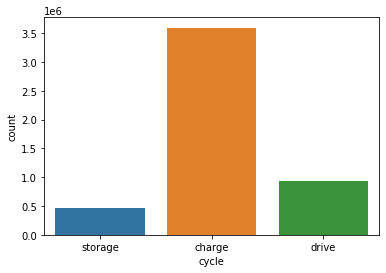

In [0]:
sns.countplot(filtered_data['cycle'])

In [8]:
bat_storage_data = filtered_data[bat_data['cycle'] == 'storage']
bat_charge_data = filtered_data[bat_data['cycle'] == 'charge']
bat_drive_data = filtered_data[bat_data['cycle'] == 'drive']
print("storage data dimensions are ", bat_storage_data.shape)
print("charge data dimensions are ", bat_charge_data.shape)
print("drive data dimensions are ", bat_drive_data.shape)

storage data dimensions are  (467495, 26)
charge data dimensions are  (3595456, 26)
drive data dimensions are  (937049, 26)


In [23]:
for col in float_cols.columns:
  vals = dict()
  counter = 0
  i = 0
  for val in bat_storage_data[col]:
    if val in vals:
      bat_storage_data.at[i, col] = counter
    else:
      counter = counter + 1
      bat_storage_data.at[i, col] = counter
      vals[val] = counter
    i += 1



ValueError: ignored

In [1]:
bat_storage_data['soh'].unique()

NameError: ignored

In [0]:
from mlxtend.frequent_patterns import apriori, association_rules

In [13]:
arm = apriori(bat_storage_data, min_support = 0.04, use_colnames = True) 

assoc_rules = association_rules(arm, metric ="confidence", min_threshold = 0.8) 
assoc_rules = assoc_rules.sort_values(['confidence', 'lift'], ascending =[False, False]) 

TypeError: ignored

In [0]:
import dill
dill.dump_session('phase-II-ml.db')